# Training an Autoencoder for MNIST

This tutorial introduces how to use `pytagi` to train a model that is able to encode the MNIST images into a latent space by using an encoder decoder architecture. Run it now in [Google Colab](https://drive.google.com/file/d/1Bkbj4QhPjXHp-2_Q23b5m9Qpt_QSDSus/view?usp=sharing).

## Load and normalize MNIST

In this tutorial we will make use of `torch` and `torchvision` to load and normalize the MNIST images. We define the batch size as well for the data processing.

In [1]:
# Uncomment the following lines to install the required packages if not already installed
# !pip install pytagi
# !pip install numpy
# !pip install tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

We create a custom collate function for the MNIST dataset.

In [2]:
def custom_collate_fn(batch):
    # batch is a list of tuples (image, label)
    batch_images, batch_labels = zip(*batch)

    # Convert to a single tensor and then to numpy
    batch_images = torch.stack(batch_images)
    batch_labels = torch.tensor(batch_labels)

    # Flatten images and labels to 1D
    batch_images = batch_images.numpy().reshape(len(batch_images), -1).flatten()
    batch_labels = batch_labels.numpy().flatten()

    return batch_images, batch_labels

In [3]:
# Data loading and preprocessing
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=custom_collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    collate_fn=custom_collate_fn,
)


We can see some of the MNIST images :)

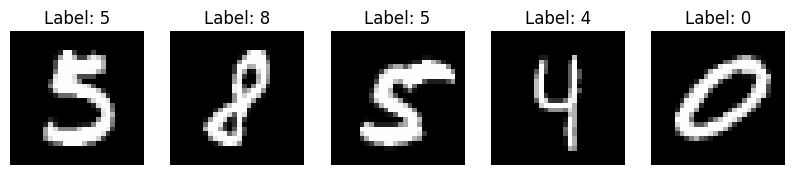

In [4]:
import matplotlib.pyplot as plt

# Get a batch from the training data loader
# Note: The custom_collate_fn flattens the data, so we need to reshape it back to image format (28x28)
# Also, the original images are grayscale, so we don't need a color map.
images, labels = next(iter(train_loader))

# Reshape the flattened images back to 28x28 for plotting
images = images.reshape(-1, 1, 28, 28)

# Display a few images
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')
plt.show()

## Define an Autoencoder

Next we define our convolutional network. Because the images are in grayscale, we specify one channel in the entrance as well as the dimension of the images. We also use average pooling after the batch normalization and use ReLU as activation function.

In [5]:
from pytagi.nn import (
    AvgPool2d,
    BatchNorm2d,
    Conv2d,
    ConvTranspose2d,
    Linear,
    OutputUpdater,
    MixtureReLU,
    Sequential,
)

# Network
encoder = Sequential(
    Conv2d(
        1,
        16,
        3,
        bias=False,
        padding=1,
        in_width=28,
        in_height=28,
    ),
    MixtureReLU(),
    BatchNorm2d(16),
    AvgPool2d(3, 2, 1, 2),
    Conv2d(16, 32, 3, bias=False, padding=1),
    MixtureReLU(),
    BatchNorm2d(32),
    AvgPool2d(3, 2, 1, 2),
    Linear(32 * 7 * 7, 128),
    MixtureReLU(),
    Linear(128, 16),
)

decoder = Sequential(
    Linear(16, 32 * 7 * 7),
    MixtureReLU(),
    ConvTranspose2d(
        32,
        32,
        3,
        bias=True,
        stride=2,
        padding=1,
        padding_type=2,
        in_width=7,
        in_height=7,
    ),
    MixtureReLU(),
    ConvTranspose2d(
        32, 16, 3, bias=True, stride=2, padding=1, padding_type=2
    ),
    MixtureReLU(),
    ConvTranspose2d(16, 1, 3, bias=True, padding=1),
)


## Train the network


In this step we can also make our model run on GPU in case we have CUDA.

In [6]:
import pytagi
encoder.to_device("cuda" if pytagi.cuda.is_available() else "cpu")
decoder.to_device("cuda" if pytagi.cuda.is_available() else "cpu")

# We can also set number of threads if we run on CPU
# encoder.set_threads(8)
# decoder.set_threads(8)

out_updater = OutputUpdater(decoder.device)

We need to also specify a sigma_v, which corresponds to the noise of the data.

In [7]:
# Training
error_rates = []
num_epochs = 10
sigma_v = 2.0

num_pixels = 28 * 28

pbar = tqdm(range(num_epochs), desc="Training Progress")
var_y = np.full((batch_size * num_pixels,), sigma_v**2, dtype=np.float32)

for epoch in pbar:
    encoder.train()
    decoder.train()

    for x, labels in train_loader:
        # Feedforward and backward pass
        _, _ = encoder(x)
        m_pred, _ = decoder(encoder.output_z_buffer)

        # Update output layer
        out_updater.update(
            output_states=decoder.output_z_buffer,
            mu_obs=x,
            var_obs=var_y,
            delta_states=decoder.input_delta_z_buffer,
        )

        # Feed backward
        decoder.backward()
        decoder.step()

        # Send updating values to encoder
        encoder.input_delta_z_buffer.copy_from(
            decoder.output_delta_z_buffer
        )

        encoder.backward()
        encoder.step()

        # Training metric (Mean Squared Error)
        error = x - m_pred
        error_rate = np.mean(np.square(error)) * 100
        error_rates.append(error_rate)

    # Averaged error
    avg_error_rate = sum(error_rates[-100:]) / 100

    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs} | training error: {avg_error_rate:.2f}%",
        refresh=False,
    )
print("Training complete.")

Epoch 10/10 | training error: 49.76%: 100%|██████████| 10/10 [02:17<00:00, 13.72s/it]

Training complete.


## Test the model
For the test, we are gonna visualize some of the reconstructed images of the test set.

In [8]:
# Testing
original_images = []
generated_images = []
encoder.eval()
decoder.eval()

for x, labels in test_loader:
    _, _ = encoder(x)
    m_pred, v_pred = decoder(encoder.output_z_buffer)

    original_images.append(x.reshape(x.shape[0], -1))
    generated_images.append(m_pred.reshape(m_pred.shape[0], -1))

We can now try to visualize some of the predictions.

(10000, 1, 28, 28)
x shape: (16, 1, 28, 28)


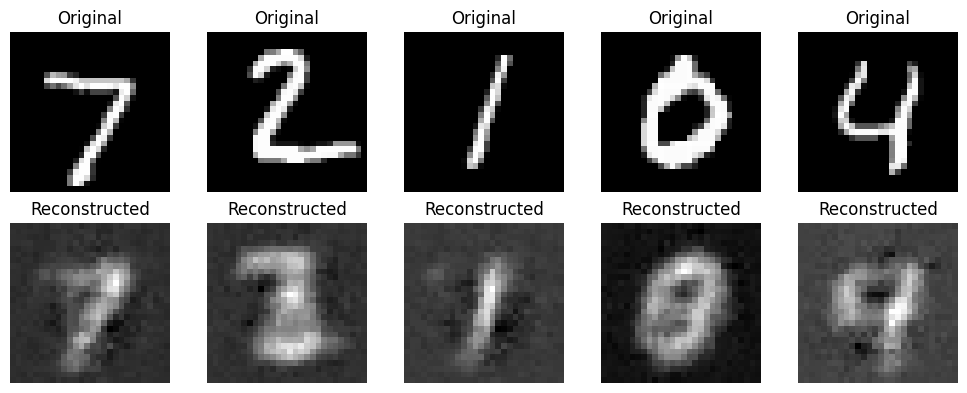

In [9]:
# Reshape original images to be (num_samples, 1, 28, 28)
original_images = np.vstack(original_images).reshape(-1, 1, 28, 28)

# Resize generated images to be (num_samples, 1, 28, 28)
generated_images = np.vstack(generated_images).reshape(-1, 1, 28, 28)
# x shape: (12544,)
# Resize x to be (num_samples, 1, 28, 28)
x = x.reshape(-1, 1, 28, 28)


print(generated_images.shape)
print("x shape:", x.shape)
# Plot original and reconstructed images
num_images_to_show = 5
fig, axes = plt.subplots(2, num_images_to_show, figsize=(10, 4))
for i in range(num_images_to_show):
    # Original images
    axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f"Original")
    axes[0, i].axis('off')

    # Reconstructed images
    axes[1, i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

As we can see, the autoencoder is working and it learns a more simple representation of the MNIST images, which is later able to reconstruct.